## Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

! pip install BeautifulSoup4
from bs4 import BeautifulSoup

import wikipedia as wp

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


# London Area

## Scraping Data from Wiki

In [2]:
#Get Data
html = wp.page("List of areas of London").html().encode("UTF-8")
df = pd.read_html(html)[1]
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [3]:
df.columns = ['Location','London borough','Post town','Postcode district','Dial Code','OS grid ref']

In [4]:
#Clean Data
df['London borough'] =  df['London borough'].apply(lambda x: x.replace('[','').replace(']','')) 
df['London borough'] =  df['London borough'].str.replace('\d+', '')
df['London borough'] =  df['London borough'].str.split(',').str[0]
df['Postcode district'] =  df['Postcode district'].str.split(',').str[0]
df['Postcode district'] =  df['Postcode district'].str.split('(').str[0]
df['Post town'] =  df['Post town'].str.split(',').str[0]
df.head()

,Location,London borough,Post town,Postcode district,Dial Code,OS grid ref
0,Abbey Wood,Bexley,LONDON,SE2,020,TQ465785
1,Acton,Ealing,LONDON,W3,020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,BEXLEY,DA5,020,TQ478728


## Scraping Data from Property Data

In [8]:
#Get Data
tables = pd.read_html("https://propertydata.co.uk/cities/london",header=0)
df2=pd.DataFrame(data=tables[0])
print(df2.shape)
df2.head()

(210, 6)


,Area,Avg yield,Avg price,£/sqft,5yr +/-,Explore data
0,BR1,3.3%,"£431,123",£461,+23%,Explore data
1,BR2,3.5%,"£489,265",£467,+24%,Explore data
2,BR3,3.6%,"£440,455",£489,+24%,Explore data
3,BR4,-,"£628,666",£451,+21%,Explore data
4,BR5,2.9%,"£450,523",£423,+23%,Explore data


In [6]:
df2.columns

Index(['Area', 'Avg yield', 'Avg price', '£/sqft', '5yr +/-', 'Explore data'], dtype='object')

In [9]:
#Clean data
del df2['Avg yield']
del df2['£/sqft']
del df2['5yr +/-']
del df2['Explore data']
df2.columns = ['Area','Avg price']
df2.rename(columns = {'Area':'Postcode District'}, inplace = True)
df2.rename(columns = {'Avg price':'Avgprice'}, inplace = True)
df2.head()

,Postcode District,Avgprice
0,BR1,"£431,123"
1,BR2,"£489,265"
2,BR3,"£440,455"
3,BR4,"£628,666"
4,BR5,"£450,523"


In [10]:
df2.columns=['Postcode district','Avgprice']

## Combining the Data

In [11]:
#Merge Data
df3=pd.merge(df, df2, how='inner', left_on='Postcode district', right_on='Postcode district')

In [12]:
print(df3.shape)
df3.head()

(512, 7)


,Location,London borough,Post town,Postcode district,Dial Code,OS grid ref,Avgprice
0,Acton,Ealing,LONDON,W3,020,TQ205805,"£540,216"
1,Addington,Croydon,CROYDON,CR0,020,TQ375645,"£343,171"
2,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,"£343,171"
3,Coombe,Croydon,CROYDON,CR0,020,TQ342647,"£343,171"
4,Croydon,Croydon,CROYDON,CR0,020,TQ335655,"£343,171"


In [13]:
df3.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            502, 503, 504, 505, 506, 507, 508, 509, 510, 511],
           dtype='int64', length=512)

In [25]:
LondonPrices = df3.sort_values('Avgprice')
LondonPrices.head()

,Location,London borough,Post town,Postcode district,Dial Code,OS grid ref,Avgprice
120,Blackfriars,City,LONDON,EC4,020,TQ318808,"£1,016,190"
121,Temple,City,LONDON,EC4,020,TQ311809,"£1,016,190"
134,Bloomsbury,Camden,LONDON,WC1,020,TQ305825,"£1,031,839"
135,Holborn,Camden,LONDON,WC1,020,TQ305815,"£1,031,839"
136,King's Cross,Camden and Islington,LONDON,WC1,020,TQ315835,"£1,031,839"


# London Population

## Scraping Data from Wiki

In [27]:
#Get the html source
html = wp.page("Asian population of London").html().encode("UTF-8")
London_df = pd.read_html(html)[4]
London_df.head()

,Rank,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population
0,1,Newham,42484,30307,37262,3930,19912,133895
1,2,Redbridge,45660,31051,16011,3000,20781,116503
2,3,Brent,58017,14381,1749,3250,28589,105986
3,4,Tower Hamlets,6787,2442,81377,8109,5786,104501
4,5,Harrow,63051,7797,1378,2629,26953,101808


## Add Coordinates

In [28]:
borough_df = pd.DataFrame( data = {

'London Borough' : ['Newham', 'Redbridge', 'Brent', 'Tower Hamlets', 'Harrow',
                'Ealing', 'Hounslow', 'Hillingdon', 'Barnet', 'Croydon', 'Waltham Forest',
                'Merton', 'Camden', 'Enfield', 'Wandsworth', 'Westminster', 'Greenwich',
                'Barking and Dagenham', 'Southwark', 'Kingston Upon Thames'],
'Latitude' : ['51.5255','51.5901','51.5673','51.5203','51.5806','51.5131','51.4609','51.5352','51.6251','51.3762','51.5886',
             '51.4098','51.5517','51.6636','51.4571','51.4975','51.4934','51.5465','51.4834','51.4123'],
'Longitude' : ['0.0352','0.0819','-0.2711','-0.0293','-0.3420','-0.3256','-0.3731','-0.4481','-0.1529','-0.0982','-0.0118',
              '-0.2108','-0.1588','-0.1043','-0.1818','-0.1357','0.0098','0.1293','-0.0821','-0.3007']})

borough_df.head()

,London Borough,Latitude,Longitude
0,Newham,51.5255,0.0352
1,Redbridge,51.5901,0.0819
2,Brent,51.5673,-0.2711
3,Tower Hamlets,51.5203,-0.0293
4,Harrow,51.5806,-0.3420


In [29]:
borough_df['Latitude'] = borough_df['Latitude'].astype('float', errors = 'ignore')
borough_df['Longitude'] = borough_df['Longitude'].astype('float', errors = 'ignore')
borough_df.dtypes

London Borough     object
Latitude          float64
Longitude         float64
dtype: object

In [30]:
address = 'London, UK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are 51.5073219, -0.1276474.


In [31]:
#Create map
London_map = folium.Map(location=[latitude, longitude], zoom_start=10)

#Add markers to map
for lat, lng, borough in zip(borough_df['Latitude'], borough_df['Longitude'], borough_df['London Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(London_map)  
    
London_map

## Explore Data with Foursquare

In [32]:
#Define Foursquare credentials
CLIENT_ID = '0IITJSNBXNENNQMBOIQCU3KACL1J2UYHUVAFHXG2TWYNR4FQ'
CLIENT_SECRET = 'JGLKTYNVRNGY5OP0Q22AYJJKU3HT5BKYOXLKHHDSUBH3CWMZ'
VERSION = '20180605' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0IITJSNBXNENNQMBOIQCU3KACL1J2UYHUVAFHXG2TWYNR4FQ
CLIENT_SECRET:JGLKTYNVRNGY5OP0Q22AYJJKU3HT5BKYOXLKHHDSUBH3CWMZ


In [33]:
#Get first borough
borough_df.loc[0, 'London Borough']

'Newham'

In [34]:
#First borough coordinates
borough_latitude = borough_df.loc[0, 'Latitude'] # borough latitude value
borough_longitude = borough_df.loc[0, 'Longitude'] # borough longitude value

borough_name = borough_df.loc[0, 'London Borough'] # borough name

print('Latitude and longitude values of {} are {}, {}.'.format(borough_name, 
                                                               borough_latitude, 
                                                               borough_longitude))

Latitude and longitude values of Newham are 51.5255, 0.0352.


In [35]:
#Top 100 venues nearby
LIMIT= 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e1363610de0d9001cbd74f8'},
 'response': {'headerLocation': 'Newham',
  'headerFullLocation': 'Newham, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 8,
  'suggestedBounds': {'ne': {'lat': 51.5300000045, 'lng': 0.04241929604043637},
   'sw': {'lat': 51.5209999955, 'lng': 0.027980703959563636}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e7b2628887783148edecd7d',
       'name': 'Delicious Café',
       'location': {'address': '566 Barking Road',
        'lat': 51.526416732217484,
        'lng': 0.030133265936175827,
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.526416732217484,
          'lng': 0.030133265936175827}],
        'distance': 365,
        'postalCode': 'E13 9JU',
      

In [36]:
#Extract category of venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
#Clean data
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Delicious Café,Café,51.526417,0.030133
1,Tesco Express,Grocery Store,51.527187,0.035118
2,Andre Moves,Home Service,51.524192,0.036145
3,Deep Blue Sea Fish & Chips,Fish & Chips Shop,51.525097,0.039410
4,West Ham Food Centre,Convenience Store,51.527451,0.031644


In [37]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

8 venues were returned by Foursquare.


### Explore boroughs in London

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
London_venues = getNearbyVenues(names= borough_df['London Borough'],
                                   latitudes= borough_df['Latitude'],
                                   longitudes= borough_df['Longitude']
                                  )

Newham
Redbridge
Brent
Tower Hamlets
Harrow
Ealing
Hounslow
Hillingdon
Barnet
Croydon
Waltham Forest
Merton
Camden
Enfield
Wandsworth
Westminster
Greenwich
Barking and Dagenham
Southwark
Kingston Upon Thames


In [40]:
print(London_venues.shape)
London_venues.head()

(412, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Newham,51.5255,0.0352,Delicious Café,51.526417,0.030133,Café
1,Newham,51.5255,0.0352,Tesco Express,51.527187,0.035118,Grocery Store
2,Newham,51.5255,0.0352,Andre Moves,51.524192,0.036145,Home Service
3,Newham,51.5255,0.0352,Deep Blue Sea Fish & Chips,51.525097,0.039410,Fish & Chips Shop
4,Newham,51.5255,0.0352,West Ham Food Centre,51.527451,0.031644,Convenience Store


In [41]:
London_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Barking and Dagenham,3,3,3,3,3,3
Barnet,4,4,4,4,4,4
Brent,8,8,8,8,8,8
Camden,29,29,29,29,29,29
Croydon,58,58,58,58,58,58
Ealing,22,22,22,22,22,22
Enfield,6,6,6,6,6,6
Greenwich,22,22,22,22,22,22
Harrow,31,31,31,31,31,31


### Analyse each Borough

In [42]:
#One hot encoding
london_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

#Add borough column back to dataframe
london_onehot['Borough'] = London_venues['Borough'] 

#Move borough column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

print(london_onehot.shape)
london_onehot.head()

(412, 126)


,Borough,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Bagel Shop,Bakery,Bar,Beer Bar,Bike Rental / Bike Share,Bookstore,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Canal Lock,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Furniture / Home Store,Gastropub,Gift Shop,Go Kart Track,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Home Service,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Lebanese Restaurant,Malay Restaurant,Market,Martial Arts Dojo,Metro Station,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Nightclub,Park,Pedestrian Plaza,Persian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Sandwich Place,Shopping Mall,Skate Park,Smoothie Shop,Spa,Sporting Goods Shop,Stationery Store,Steakhouse,Street Food Gathering,Strip Club,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Shop,Women's Store
0,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
#Group rows by Borough
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
print(london_grouped.shape)
london_grouped

(20, 126)


,Borough,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Bagel Shop,Bakery,Bar,Beer Bar,Bike Rental / Bike Share,Bookstore,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Canal Lock,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Furniture / Home Store,Gastropub,Gift Shop,Go Kart Track,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Home Service,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Lebanese Restaurant,Malay Restaurant,Market,Martial Arts Dojo,Metro Station,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Nightclub,Park,Pedestrian Plaza,Persian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Sandwich Place,Shopping Mall,Skate Park,Smoothie Shop,Spa,Sporting Goods Shop,Stationery Store,Steakhouse,Street Food Gathering,Strip Club,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Shop,Women's Store
0,Barking and Dagenham,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000,0.000000,0.0000,0.0000,0.000000,0.333333,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
1,Barnet,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.250000,0.250000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250,0.000000,0.000000,0.000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.25,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
2,Brent,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0

### Top 5 venues per borough

In [44]:
num_top_venues = 5

for hood in london_grouped['Borough']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
                        venue  freq
0  Construction & Landscaping  0.33
1                        Lake  0.33
2                        Park  0.33
3         American Restaurant  0.00
4                      Museum  0.00


----Barnet----
                 venue  freq
0  Rental Car Location  0.25
1             Bus Stop  0.25
2                 Café  0.25
3         Home Service  0.25
4  American Restaurant  0.00


----Brent----
                       venue  freq
0     Furniture / Home Store  0.12
1  Middle Eastern Restaurant  0.12
2                       Café  0.12
3                 Food Truck  0.12
4                Supermarket  0.12


----Camden----
         venue  freq
0         Café  0.07
1  Pizza Place  0.07
2       Bakery  0.07
3    Gastropub  0.07
4  Coffee Shop  0.07


----Croydon----
            venue  freq
0     Coffee Shop  0.17
1  Clothing Store  0.10
2             Pub  0.05
3        Platform  0.05
4            Café  0.05


----Ealing----
                

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

borough_venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Construction & Landscaping,Lake,Park,Women's Store,Fish & Chips Shop,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant
1,Barnet,Bus Stop,Home Service,Café,Rental Car Location,Women's Store,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Doner Restaurant
2,Brent,Middle Eastern Restaurant,IT Services,Bus Station,Fast Food Restaurant,Food Truck,Supermarket,Café,Furniture / Home Store,Farmers Market,Women's Store
3,Camden,Café,Gym / Fitness Center,Coffee Shop,Gastropub,Pizza Place,Bakery,Museum,Cosmetics Shop,Deli / Bodega,Pharmacy
4,Croydon,Coffee Shop,Clothing Store,Platform,Café,Hotel,Bookstore,Pub,Sushi Restaurant,Portuguese Restaurant,Caribbean Restaurant
5,Ealing,Hotel,Supermarket,Grocery Store,Fast Food Restaurant,Coffee Shop,Furniture / Home Store,Farmers Market,Park,Doner Restaurant,Pharmacy
6,Enfield,Pub,Auto Workshop,Bakery,Restaurant,Tennis Court,Coffee Shop,Diner,Discount Store,Dessert Shop,Fish & Chips Shop
7,Greenwich,Park,Chinese Restaurant,Movie Theater,Bus Stop,Spa,Brewery,Coffee Shop,Pub,Portuguese Restaurant,Szechuan Restaurant
8,Harrow,Coffee Shop,Clothing Store,Gym,Pizza Place,Women's Store,Pub,Pharmacy,Movie Theater,Middle Eastern Restaurant,Italian Restaurant
9,Hillingdon,Chinese Restaurant,Breakfast Spot,Martial Arts Dojo,Burger Joint,Construction & Landscaping,Discount Store,Doner Restaurant,Donut Shop,Electronics Store,Falafel Restaurant


## Cluster Boroughs

In [47]:
# set number of clusters
kclusters = 6

london_grouped_clustering = london_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 4, 1, 1, 1, 3, 0, 1, 1, 5], dtype=int32)

In [48]:
#New DF to cluster populations and venues
london_merged = London_df.merge(borough_venues_sorted, how='inner', left_on='London Borough', right_on='Borough')
london_merged['Cluster Labels'] = kmeans.labels_
london_merged.head()

,Rank,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,1,Newham,42484,30307,37262,3930,19912,133895,Newham,Café,Grocery Store,Convenience Store,Home Service,Park,Fish & Chips Shop,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,2
1,2,Redbridge,45660,31051,16011,3000,20781,116503,Redbridge,Indian Restaurant,Supermarket,Pizza Place,Pharmacy,Pub,Coffee Shop,Park,Sandwich Place,Café,Middle Eastern Restaurant,4
2,3,Brent,58017,14381,1749,3250,28589,105986,Brent,Middle Eastern Restaurant,IT Services,Bus Station,Fast Food Restaurant,Food Truck,Supermarket,Café,Furniture / Home Store,Farmers Market,Women's Store,1
3,4,Tower Hamlets,6787,2442,81377,8109,5786,104501,Tower Hamlets,Pizza Place,Canal Lock,Persian Restaurant,Coffee Shop,Go Kart Track,Thrift / Vintage Store,Lebanese Restaurant,Steakhouse,Recreation Center,Skate Park,1
4,5,Harrow,63051,7797,1378,2629,26953,101808,Harrow,Coffee Shop,Clothing Store,Gym,Pizza Place,Women's Store,Pub,Pharmacy,Movie Theater,Middle Eastern Restaurant,Italian Restaurant,1


In [49]:
#Add coordinates
london_merged[['Latitude', 'Longitude']] = borough_df[['Latitude', 'Longitude']]
london_merged['Latitude'] = london_merged['Latitude'].astype(float)
london_merged['Longitude'] = london_merged['Longitude'].astype(float)
london_merged.head()

,Rank,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
0,1,Newham,42484,30307,37262,3930,19912,133895,Newham,Café,Grocery Store,Convenience Store,Home Service,Park,Fish & Chips Shop,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,2,51.5255,0.0352
1,2,Redbridge,45660,31051,16011,3000,20781,116503,Redbridge,Indian Restaurant,Supermarket,Pizza Place,Pharmacy,Pub,Coffee Shop,Park,Sandwich Place,Café,Middle Eastern Restaurant,4,51.5901,0.0819
2,3,Brent,58017,14381,1749,3250,28589,105986,Brent,Middle Eastern Restaurant,IT Services,Bus Station,Fast Food Restaurant,Food Truck,Supermarket,Café,Furniture / Home Store,Farmers Market,Women's Store,1,51.5673,-0.2711
3,4,Tower Hamlets,6787,2442,81377,8109,5786,104501,Tower Hamlets,Pizza Place,Canal Lock,Persian Restaurant,Coffee Shop,Go Kart Track,Thrift / Vintage Store,Lebanese Restaurant,Steakhouse,Recreation Center,Skate Park,1,51.5203,-0.0293
4,5,Harrow,63051,7797,1378,2629,26953,101808,Harrow,Coffee Shop,Clothing Store,Gym,Pizza Place,Women's Store,Pub,Pharmacy,Movie Theater,Middle Eastern Restaurant,Italian Restaurant,1,51.5806,-0.3420


In [50]:
LondonPopulation = london_merged
LondonPopulation

,Rank,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
0,1,Newham,42484,30307,37262,3930,19912,133895,Newham,Café,Grocery Store,Convenience Store,Home Service,Park,Fish & Chips Shop,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,2,51.5255,0.0352
1,2,Redbridge,45660,31051,16011,3000,20781,116503,Redbridge,Indian Restaurant,Supermarket,Pizza Place,Pharmacy,Pub,Coffee Shop,Park,Sandwich Place,Café,Middle Eastern Restaurant,4,51.5901,0.0819
2,3,Brent,58017,14381,1749,3250,28589,105986,Brent,Middle Eastern Restaurant,IT Services,Bus Station,Fast Food Restaurant,Food Truck,Supermarket,Café,Furniture / Home Store,Farmers Market,Women's Store,1,51.5673,-0.2711
3,4,Tower Hamlets,6787,2442,81377,8109,5786,104501,Tower Hamlets,Pizza Place,Canal Lock,Persian Restaurant,Coffee Shop,Go Kart Track,Thrift / Vintage Store,Lebanese Restaurant,Steakhouse,Recreation Center,Skate Park,1,51.5203,-0.0293
4,5,Harrow,63051,7797,1378,2629,26953,101808,Harrow,Coffee Shop,Clothing Store,Gym,Pizza Place,Women's Store,Pub,Pharmacy,Movie Theater,Middle Eastern Restaurant,Italian Restaurant,1,51.5806,-0.3420
5,6,Ealing,48240,14711,1786,4132,31570,100439,Ealing,Hotel,Supermarket,Grocery Store,Fast Food Restaurant,Coffee Shop,Furniture / Home Store,Farmers Market,Park,Doner Restaurant,Pharmacy,3,51.5131,-0.3256
6,7,Hounslow,48161,13676,2189,2405,20826,87257,Hounslow,Indian Restaurant,Auto Garage,Grocery Store,Pizza Place,Hotel,Middle Eastern Restaurant,Dessert Shop,Diner,Department Store,Discount Store,0,51.4609,-0.3731
7,8,Hillingdon,36795,9200,2639,2889,17730,69253,Hillingdon,Chinese Restaurant,Breakfast Spot,Martial Arts Dojo,Burger Joint,Construction & Landscaping,Discount Store,Doner Restaurant,Donut Shop,Electronics Store,Falafel Restaurant,1,51.5352,-0.4481
8,9,Barnet,27920,5344,2215,8259,22180,65918,Barnet,Bus Stop,Home Service,Café,Rental Car Location,Women's Store,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Doner Restaurant,1,51.6251,-0.1529
9,10,Croydon,24660,10865,2570,3925,17607,59627,Croydon,Coffee Shop,Clothing Store,Platform,Café,Hotel,Bookstore,Pub,Sushi Restaurant,Portuguese Restaurant,Caribbean Restaurant,5,51.3762,-0.0982


In [51]:
#Visualise clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Borough'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

### Cluster 1

In [52]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Chinese Population'], ascending = False)

,Rank,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
6,7,Hounslow,48161,13676,2189,2405,20826,87257,Hounslow,Indian Restaurant,Auto Garage,Grocery Store,Pizza Place,Hotel,Middle Eastern Restaurant,Dessert Shop,Diner,Department Store,Discount Store,0,51.4609,-0.3731


### Cluster 2

In [53]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Chinese Population'], ascending = False)

,Rank,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
8,9,Barnet,27920,5344,2215,8259,22180,65918,Barnet,Bus Stop,Home Service,Café,Rental Car Location,Women's Store,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Doner Restaurant,1,51.6251,-0.1529
3,4,Tower Hamlets,6787,2442,81377,8109,5786,104501,Tower Hamlets,Pizza Place,Canal Lock,Persian Restaurant,Coffee Shop,Go Kart Track,Thrift / Vintage Store,Lebanese Restaurant,Steakhouse,Recreation Center,Skate Park,1,51.5203,-0.0293
15,16,Westminster,7213,2328,6299,5917,10105,31862,Westminster,Coffee Shop,Hotel,Sandwich Place,Theater,Sushi Restaurant,Indian Restaurant,Café,Pub,Juice Bar,Sporting Goods Shop,1,51.4975,-0.1357
16,17,Greenwich,7836,2594,1645,5061,12758,29894,Greenwich,Park,Chinese Restaurant,Movie Theater,Bus Stop,Spa,Brewery,Coffee Shop,Pub,Portuguese Restaurant,Szechuan Restaurant,1,51.4934,0.0098
2,3,Brent,58017,14381,1749,3250,28589,105986,Brent,Middle Eastern Restaurant,IT Services,Bus Station,Fast Food Restaurant,Food Truck,Supermarket,Café,Furniture / Home Store,Farmers Market,Women's Store,1,51.5673,-0.2711
7,8,Hillingdon,36795,9200,2639,2889,17730,69253,Hillingdon,Chinese Restaurant,Breakfast Spot,Martial Arts Dojo,Burger Joint,Construction & Landscaping,Discount Store,Doner Restaurant,Donut Shop,Electronics Store,Falafel Restaurant,1,51.5352,-0.4481
19,20,Kingston Upon Thames,6325,3009,892,2883,13043,26152,Kingston Upon Thames,Café,Coffee Shop,Bakery,Clothing Store,Department Store,Bookstore,Sushi Restaurant,Italian Restaurant,Supermarket,Japanese Restaurant,1,51.4123,-0.3007
4,5,Harrow,63051,7797,1378,2629,26953,101808,Harrow,Coffee Shop,Clothing Store,Gym,Pizza Place,Women's Store,Pub,Pharmacy,Movie Theater,Middle Eastern Restaurant,Italian Restaurant,1,51.5806,-0.3420
11,12,Merton,8106,7337,2216,2618,15866,36143,Merton,Grocery Store,Indian Restaurant,Bakery,Fast Food Restaurant,Park,Diner,Pizza Place,Coffee Shop,Café,Pub,1,51.4098,-0.2108


### Cluster 3

In [54]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Chinese Population'], ascending = False)

,Rank,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
0,1,Newham,42484,30307,37262,3930,19912,133895,Newham,Café,Grocery Store,Convenience Store,Home Service,Park,Fish & Chips Shop,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,2,51.5255,0.0352


### Cluster 4

In [55]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Chinese Population'], ascending = False)

,Rank,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
18,19,Southwark,5819,1623,3912,8074,7764,27192,Southwark,Pub,Lake,Park,Café,Skate Park,Building,Greek Restaurant,Farmers Market,Department Store,Dessert Shop,3,51.4834,-0.0821
12,13,Camden,6083,1489,12503,6493,8878,35446,Camden,Café,Gym / Fitness Center,Coffee Shop,Gastropub,Pizza Place,Bakery,Museum,Cosmetics Shop,Deli / Bodega,Pharmacy,3,51.5517,-0.1588
5,6,Ealing,48240,14711,1786,4132,31570,100439,Ealing,Hotel,Supermarket,Grocery Store,Fast Food Restaurant,Coffee Shop,Furniture / Home Store,Farmers Market,Park,Doner Restaurant,Pharmacy,3,51.5131,-0.3256
14,15,Wandsworth,8642,9718,1493,3715,9770,33338,Wandsworth,Pub,Café,Grocery Store,Coffee Shop,Hotel,Park,Pizza Place,Indian Restaurant,Bagel Shop,Bakery,3,51.4571,-0.1818
10,11,Waltham Forest,9134,26347,4632,2579,11697,54389,Waltham Forest,Grocery Store,Pub,Coffee Shop,Deli / Bodega,Concert Hall,Pizza Place,Field,Pool,Vegetarian / Vegan Restaurant,Gym,3,51.5886,-0.0118
17,18,Barking and Dagenham,7436,8007,7701,1315,5135,29594,Barking and Dagenham,Construction & Landscaping,Lake,Park,Women's Store,Fish & Chips Shop,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,3,51.5465,0.1293


### Cluster 5

In [56]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Chinese Population'], ascending = False)

,Rank,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
1,2,Redbridge,45660,31051,16011,3000,20781,116503,Redbridge,Indian Restaurant,Supermarket,Pizza Place,Pharmacy,Pub,Coffee Shop,Park,Sandwich Place,Café,Middle Eastern Restaurant,4,51.5901,0.0819
13,14,Enfield,11648,2594,5599,2588,12464,34893,Enfield,Pub,Auto Workshop,Bakery,Restaurant,Tennis Court,Coffee Shop,Diner,Discount Store,Dessert Shop,Fish & Chips Shop,4,51.6636,-0.1043


## Cluster 6

In [57]:
london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Chinese Population'], ascending = False)

,Rank,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
9,10,Croydon,24660,10865,2570,3925,17607,59627,Croydon,Coffee Shop,Clothing Store,Platform,Café,Hotel,Bookstore,Pub,Sushi Restaurant,Portuguese Restaurant,Caribbean Restaurant,5,51.3762,-0.0982


# Visualising Results

In [96]:
url = "london_prices_clean2.csv"
LondonPrices = pd.read_csv(url)
LondonPrices

,London Borough,Avgprice
0,Bexley,362879
1,Barking and Dagenham,319211
2,Croydon,384420
3,Sutton,386165
4,Hounslow,474877
5,Enfield,485936
6,Ealing,504298
7,Redbridge,446953
8,Havering,409489
9,Hillingdon,435438


In [67]:
LondonPopulation.head()

,Rank,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
0,1,Newham,42484,30307,37262,3930,19912,133895,Newham,Café,Grocery Store,Convenience Store,Home Service,Park,Fish & Chips Shop,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,2,51.5255,0.0352
1,2,Redbridge,45660,31051,16011,3000,20781,116503,Redbridge,Indian Restaurant,Supermarket,Pizza Place,Pharmacy,Pub,Coffee Shop,Park,Sandwich Place,Café,Middle Eastern Restaurant,4,51.5901,0.0819
2,3,Brent,58017,14381,1749,3250,28589,105986,Brent,Middle Eastern Restaurant,IT Services,Bus Station,Fast Food Restaurant,Food Truck,Supermarket,Café,Furniture / Home Store,Farmers Market,Women's Store,1,51.5673,-0.2711
3,4,Tower Hamlets,6787,2442,81377,8109,5786,104501,Tower Hamlets,Pizza Place,Canal Lock,Persian Restaurant,Coffee Shop,Go Kart Track,Thrift / Vintage Store,Lebanese Restaurant,Steakhouse,Recreation Center,Skate Park,1,51.5203,-0.0293
4,5,Harrow,63051,7797,1378,2629,26953,101808,Harrow,Coffee Shop,Clothing Store,Gym,Pizza Place,Women's Store,Pub,Pharmacy,Movie Theater,Middle Eastern Restaurant,Italian Restaurant,1,51.5806,-0.3420


## Chinese Population Vs Price

In [73]:
%%capture
! pip install seaborn

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [69]:
#Merge London Prices DF with London Population DF
ScatterDF=pd.merge(LondonPrices, LondonPopulation, how='inner', left_on='London Borough', right_on='London Borough')

In [82]:
ScatterDF.columns = ScatterDF.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [86]:
print(ScatterDF.shape)
ScatterDF

(19, 23)


,london_borough,avgprice,rank,indian_population,pakistani_population,bangladeshi_population,chinese_population,other_asian_population,total_asian_population,borough,1st_most_common_venue,2nd_most_common_venue,3rd_most_common_venue,4th_most_common_venue,5th_most_common_venue,6th_most_common_venue,7th_most_common_venue,8th_most_common_venue,9th_most_common_venue,10th_most_common_venue,cluster_labels,latitude,longitude
0,Barking and Dagenham,319211,18,7436,8007,7701,1315,5135,29594,Barking and Dagenham,Construction & Landscaping,Lake,Park,Women's Store,Fish & Chips Shop,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,3,51.5465,0.1293
1,Croydon,384420,10,24660,10865,2570,3925,17607,59627,Croydon,Coffee Shop,Clothing Store,Platform,Café,Hotel,Bookstore,Pub,Sushi Restaurant,Portuguese Restaurant,Caribbean Restaurant,5,51.3762,-0.0982
2,Hounslow,474877,7,48161,13676,2189,2405,20826,87257,Hounslow,Indian Restaurant,Auto Garage,Grocery Store,Pizza Place,Hotel,Middle Eastern Restaurant,Dessert Shop,Diner,Department Store,Discount Store,0,51.4609,-0.3731
3,Enfield,485936,14,11648,2594,5599,2588,12464,34893,Enfield,Pub,Auto Workshop,Bakery,Restaurant,Tennis Court,Coffee Shop,Diner,Discount Store,Dessert Shop,Fish & Chips Shop,4,51.6636,-0.1043
4,Ealing,504298,6,48240,14711,1786,4132,31570,100439,Ealing,Hotel,Supermarket,Grocery Store,Fast Food Restaurant,Coffee Shop,Furniture / Home Store,Farmers Market,Park,Doner Restaurant,Pharmacy,3,51.5131,-0.3256
5,Redbridge,446953,2,45660,31051,16011,3000,20781,116503,Redbridge,Indian Restaurant,Supermarket,Pizza Place,Pharmacy,Pub,Coffee Shop,Park,Sandwich Place,Café,Middle Eastern Restaurant,4,51.5901,0.0819
6,Hillingdon,435438,8,36795,9200,2639,2889,17730,69253,Hillingdon,Chinese Restaurant,Breakfast Spot,Martial Arts Dojo,Burger Joint,Construction & Landscaping,Discount Store,Doner Restaurant,Donut Shop,Electronics Store,Falafel Restaurant,1,51.5352,-0.4481
7,Newham,427971,1,42484,30307,37262,3930,19912,133895,Newham,Café,Grocery Store,Convenience Store,Home Service,Park,Fish & Chips Shop,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,2,51.5255,0.0352
8,Greenwich,461623,17,7836,2594,1645,5061,12758,29894,Greenwich,Park,Chinese Restaurant,Movie Theater,Bus Stop,Spa,Brewery,Coffee Shop,Pub,Portuguese Restaurant,Szechuan Restaurant,1,51.4934,0.0098
9,Merton,532821,12,8106,7337,2216,2618,15866,36143,Merton,Grocery Store,Indian Restaurant,Bakery,Fast Food Restaurant,Park,Diner,Pizza Place,Coffee Shop,Café,Pub,1,51.4098,-0.2108


In [88]:
print(ScatterDF.dtypes)

london_borough             object
avgprice                    int64
rank                        int64
indian_population           int64
pakistani_population        int64
bangladeshi_population      int64
chinese_population          int64
other_asian_population      int64
total_asian_population      int64
borough                    object
1st_most_common_venue      object
2nd_most_common_venue      object
3rd_most_common_venue      object
4th_most_common_venue      object
5th_most_common_venue      object
6th_most_common_venue      object
7th_most_common_venue      object
8th_most_common_venue      object
9th_most_common_venue      object
10th_most_common_venue     object
cluster_labels              int32
latitude                  float64
longitude                 float64
dtype: object


(0, 1629676.5609814932)

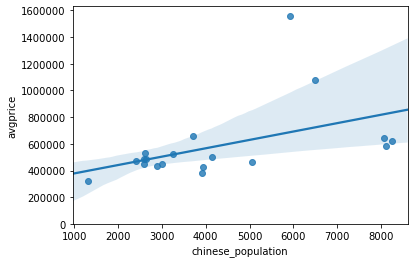

In [94]:
#Create Scatter Plot
sns.regplot(x="chinese_population", y="avgprice", data=ScatterDF)
plt.ylim(0,)

In [116]:
#Final Table With Relevent Data
ScatterDF.sort_values(by=['chinese_population'], inplace=True, ascending=False)

,london_borough,avgprice,chinese_population,1st_most_common_venue,2nd_most_common_venue,3rd_most_common_venue,4th_most_common_venue
14,Barnet,618697,8259,Bus Stop,Home Service,Café,Rental Car Location
13,Tower Hamlets,584328,8109,Pizza Place,Canal Lock,Persian Restaurant,Coffee Shop
15,Southwark,645050,8074,Pub,Lake,Park,Café
17,Camden,1076931,6493,Café,Gym / Fitness Center,Coffee Shop,Gastropub
18,Westminster,1559330,5917,Coffee Shop,Hotel,Sandwich Place,Theater
8,Greenwich,461623,5061,Park,Chinese Restaurant,Movie Theater,Bus Stop
4,Ealing,504298,4132,Hotel,Supermarket,Grocery Store,Fast Food Restaurant
7,Newham,427971,3930,Café,Grocery Store,Convenience Store,Home Service
1,Croydon,384420,3925,Coffee Shop,Clothing Store,Platform,Café
16,Wandsworth,660549,3715,Pub,Café,Grocery Store,Coffee Shop


## Explore Top 3 Locations

### Barnet

In [118]:
#Define Location
address = '51.6251, -0.1529'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

51.6254498 -0.153218517092993


In [128]:
#Define Search Radius
search_query = 'Chinese'
radius = 5000
print(search_query + ' .... OK!')

Chinese .... OK!


In [129]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=0IITJSNBXNENNQMBOIQCU3KACL1J2UYHUVAFHXG2TWYNR4FQ&client_secret=JGLKTYNVRNGY5OP0Q22AYJJKU3HT5BKYOXLKHHDSUBH3CWMZ&ll=51.6254498,-0.153218517092993&v=20180605&query=Chinese&radius=5000&limit=100'

In [130]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e13792a9da7ee00289b5d36'},
 'response': {'venues': [{'id': '4f8db193e4b05cdaa118f17b',
    'name': 'Chinese',
    'location': {'lat': 51.61607877873854,
     'lng': -0.13272060067309882,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.61607877873854,
       'lng': -0.13272060067309882}],
     'distance': 1759,
     'cc': 'GB',
     'country': 'United Kingdom',
     'formattedAddress': ['United Kingdom']},
    'categories': [{'id': '4bf58dd8d48988d145941735',
      'name': 'Chinese Restaurant',
      'pluralName': 'Chinese Restaurants',
      'shortName': 'Chinese',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1578334510',
    'hasPerk': False},
   {'id': '516d4b05e4b0aced3b68e637',
    'name': 'Chinese Golden Buffet',
    'location': {'lat': 51.63286052422765,
     'lng': -0.12629351425609106,
     'labeledLatLngs': [{'label': 'di

In [140]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
print(dataframe.shape)
dataframe.head()

(22, 17)


,id,name,categories,referralId,hasPerk,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.country,location.formattedAddress,location.address,location.postalCode,location.city,location.state,venuePage.id
0,4f8db193e4b05cdaa118f17b,Chinese,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1578334510,False,51.616079,-0.132721,"[{'label': 'display', 'lat': 51.61607877873854...",1759,GB,United Kingdom,[United Kingdom],NaN,NaN,NaN,NaN,NaN
1,516d4b05e4b0aced3b68e637,Chinese Golden Buffet,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1578334510,False,51.632861,-0.126294,"[{'label': 'display', 'lat': 51.63286052422765...",2035,GB,United Kingdom,[United Kingdom],NaN,NaN,NaN,NaN,NaN
2,4c5b0bfa15aaef3b4a19c580,Honeymoon Chinese Restaurant,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1578334510,False,51.632137,-0.128725,"[{'label': 'display', 'lat': 51.6321368342271,...",1849,GB,United Kingdom,"[84 Crown Lane, Southgate, Greater London, N14...",84 Crown Lane,N14 5EN,Southgate,Greater London,NaN
3,4bd4a67f6f649521bdd36dec,Wood Green Chinese Restaurant,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1578334510,False,51.614642,-0.128742,"[{'label': 'display', 'lat': 51.614642, 'lng':...",2075,GB,United Kingdom,"[138 High Road, Wood Green, Greater London, N2...",138 High Road,N22 6EB,Wood Green,Greater London,NaN
4,51f2d55a498e87240a32f1bd,Chinese Restaurant,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1578334510,False,51.595484,-0.112953,"[{'label': 'display', 'lat': 51.595484, 'lng':...",4344,GB,United Kingdom,[United Kingdom],NaN,NaN,NaN,NaN,NaN


### Tower Hamlets

In [141]:
address = '51.5203, -0.0293'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

51.52037845 -0.0293909613495467


In [143]:
search_query = 'Chinese'
radius = 5000
print(search_query + ' .... OK!')

Chinese .... OK!


In [144]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=0IITJSNBXNENNQMBOIQCU3KACL1J2UYHUVAFHXG2TWYNR4FQ&client_secret=JGLKTYNVRNGY5OP0Q22AYJJKU3HT5BKYOXLKHHDSUBH3CWMZ&ll=51.52037845,-0.0293909613495467&v=20180605&query=Chinese&radius=5000&limit=100'

In [145]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e137abe211536001b72c8a5'},
 'response': {'venues': [{'id': '4d2f3822a6df6dcb6901e17a',
    'name': 'Chinese Overseas',
    'location': {'lat': 51.53980850154671,
     'lng': -0.0002149742963665899,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.53980850154671,
       'lng': -0.0002149742963665899}],
     'distance': 2959,
     'cc': 'GB',
     'country': 'United Kingdom',
     'formattedAddress': ['United Kingdom']},
    'categories': [{'id': '4bf58dd8d48988d145941735',
      'name': 'Chinese Restaurant',
      'pluralName': 'Chinese Restaurants',
      'shortName': 'Chinese',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1578335006',
    'hasPerk': False},
   {'id': '4bdd413a645e0f47b42e6b19',
    'name': 'Lotus Chinese Floating Restaurant',
    'location': {'address': '9 Oakland Quay',
     'crossStreet': 'Inner Millwall Dock',


In [146]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
print(dataframe.shape)
dataframe.head()

(50, 18)


,id,name,categories,referralId,hasPerk,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.country,location.formattedAddress,location.address,location.crossStreet,location.postalCode,location.city,location.state,venuePage.id
0,4d2f3822a6df6dcb6901e17a,Chinese Overseas,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1578335006,False,51.539809,-0.000215,"[{'label': 'display', 'lat': 51.53980850154671...",2959,GB,United Kingdom,[United Kingdom],NaN,NaN,NaN,NaN,NaN,NaN
1,4bdd413a645e0f47b42e6b19,Lotus Chinese Floating Restaurant,"[{'id': '4bf58dd8d48988d1f5931735', 'name': 'D...",v-1578335006,False,51.496868,-0.016209,"[{'label': 'display', 'lat': 51.496868, 'lng':...",2771,GB,United Kingdom,"[9 Oakland Quay (Inner Millwall Dock), Isle of...",9 Oakland Quay,Inner Millwall Dock,E14 9RH,Isle of Dogs,Greater London,NaN
2,580df0f838fa3e23423edd89,Chinese Association of Tower Hamlets 東倫敦華人協會,"[{'id': '52e81612bcbc57f1066b7a34', 'name': 'C...",v-1578335006,False,51.511680,-0.028673,"[{'label': 'display', 'lat': 51.51168, 'lng': ...",969,GB,United Kingdom,"[680 Commercial Road, London, Greater London, ...",680 Commercial Road,NaN,E14 7HA,London,Greater London,NaN
3,4c6ac05c1a6620a199e0668c,Karwoo Chinese,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1578335006,False,51.517638,-0.039586,"[{'label': 'display', 'lat': 51.517638, 'lng':...",769,GB,United Kingdom,[United Kingdom],NaN,NaN,NaN,NaN,NaN,NaN
4,4f31bcf2bb3d392853d3b499,Chinese Church In London,[],v-1578335006,False,51.521802,-0.046606,"[{'label': 'display', 'lat': 51.52180192576901...",1202,GB,United Kingdom,"[166 shaftesbury avenue, London, Greater Londo...",166 shaftesbury avenue,NaN,NaN,London,Greater London,NaN


### Southwark

In [148]:
address = '51.4834, -0.0821'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

51.4824708 -0.0811942


In [149]:
search_query = 'Chinese'
radius = 5000
print(search_query + ' .... OK!')

Chinese .... OK!


In [150]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=0IITJSNBXNENNQMBOIQCU3KACL1J2UYHUVAFHXG2TWYNR4FQ&client_secret=JGLKTYNVRNGY5OP0Q22AYJJKU3HT5BKYOXLKHHDSUBH3CWMZ&ll=51.4824708,-0.0811942&v=20180605&query=Chinese&radius=5000&limit=100'

In [151]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e137b4de826ac0028cd02be'},
 'response': {'venues': [{'id': '4bec4540b68520a11adf1187',
    'name': 'Chinese Church (New Soho Congregation)',
    'location': {'address': '166A Shaftesbury Ave',
     'lat': 51.51420700875029,
     'lng': -0.12761785008703053,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.51420700875029,
       'lng': -0.12761785008703053}],
     'distance': 4778,
     'postalCode': 'WC2H 8JB',
     'cc': 'GB',
     'city': 'London',
     'state': 'Greater London',
     'country': 'United Kingdom',
     'formattedAddress': ['166A Shaftesbury Ave',
      'London',
      'Greater London',
      'WC2H 8JB',
      'United Kingdom']},
    'categories': [{'id': '4bf58dd8d48988d132941735',
      'name': 'Church',
      'pluralName': 'Churches',
      'shortName': 'Church',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/religious_church_',
       'suffix': '.png'},
      'primary': True}],
    'refer

In [152]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
print(dataframe.shape)
dataframe.head()

(50, 18)


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,venuePage.id
0,4bec4540b68520a11adf1187,Chinese Church (New Soho Congregation),"[{'id': '4bf58dd8d48988d132941735', 'name': 'C...",v-1578335144,False,166A Shaftesbury Ave,51.514207,-0.127618,"[{'label': 'display', 'lat': 51.51420700875029...",4778,WC2H 8JB,GB,London,Greater London,United Kingdom,"[166A Shaftesbury Ave, London, Greater London,...",NaN,NaN
1,4fe76af6e4b02e429469b6d2,Golden Palace Chinese,"[{'id': '4bf58dd8d48988d120951735', 'name': 'F...",v-1578335144,False,NaN,51.481096,-0.073197,"[{'label': 'display', 'lat': 51.48109623013717...",575,NaN,GB,NaN,NaN,United Kingdom,[United Kingdom],NaN,NaN
2,4bdd413a645e0f47b42e6b19,Lotus Chinese Floating Restaurant,"[{'id': '4bf58dd8d48988d1f5931735', 'name': 'D...",v-1578335144,False,9 Oakland Quay,51.496868,-0.016209,"[{'label': 'display', 'lat': 51.496868, 'lng':...",4780,E14 9RH,GB,Isle of Dogs,Greater London,United Kingdom,"[9 Oakland Quay (Inner Millwall Dock), Isle of...",Inner Millwall Dock,NaN
3,4bacdf8af964a52061143be3,Sanxia Chinese,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1578335144,False,29 Goodge St,51.519680,-0.134954,"[{'label': 'display', 'lat': 51.51967954397749...",5570,W1T 2PP,GB,Fitzrovia,Greater London,United Kingdom,"[29 Goodge St, Fitzrovia, Greater London, W1T ...",NaN,NaN
4,4ac518ddf964a52062a920e3,Imperial City Chinese Cuisine,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1578335144,False,Basement Royal Exchange 1a Cornhill,51.513522,-0.087309,"[{'label': 'display', 'lat': 51.51352199860021...",3482,EC3V 3LL,GB,London,Greater London,United Kingdom,"[Basement Royal Exchange 1a Cornhill, London, ...",NaN,348926200
